In [ ]:
import sys
sys.path.append('/home/labs/amit/noamsh/repos/MM_2023')

In [2]:
from pathlib import Path

from omegaconf import OmegaConf
import anndata as ad
import scanpy as sc

from sc_classification.train_test_split import split_adata

In [3]:
# load configuration
config_path = '/home/labs/amit/noamsh/repos/MM_2023/config.yaml'
conf = OmegaConf.load(config_path)

In [4]:
adata_path = Path(conf.outputs.output_dir, conf.outputs.processed_adata_file_name)
adata = ad.read_h5ad(adata_path)

In [5]:
# drop LowQ cells from annotations
num_cells_before_drop = len(adata.obs)
adata = adata[adata.obs[conf.annotation.cell_type_columns] != "LowQ"]
num_cells_after_drop = len(adata.obs)
number_of_cells_droped = num_cells_before_drop - num_cells_after_drop
print(f"before: {num_cells_before_drop}, after: {num_cells_after_drop}, droped: {number_of_cells_droped} cells")

before: 276268, after: 130257, droped: 146011 cells


In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Received a view of an AnnData. Making a copy.


In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [ ]:
adata_train, adata_test = split_adata(adata, split_by_obs_column=conf.annotation.patient_id_column_name)

## gene selection


In [ ]:
from pre_processing.black_list import drop_blacklist_genes_by_prefix

sc.pp.highly_variable_genes(adata_train, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_train)
drop_blacklist_genes_by_prefix(adata, conf.sc_classification.gene_selection_prefix_blacklist)

In [ ]:
adata_train.raw = adata_train
adata_test.raw = adata_test

In [ ]:
var_names = adata_train.var_names.intersection(adata_test.var_names)

adata_train = adata_train[:, var_names]
adata_test = adata_test[:, var_names]

In [ ]:
## building neighborhood graph

In [ ]:
sc.pp.pca(adata_train)
sc.pp.neighbors(adata_train, n_neighbors=10)
sc.tl.umap(adata_train)

In [ ]:
sc.pl.umap(adata_train, color=conf.annotation.cell_type_columns)

In [ ]:
# ingest - PC vs other

In [ ]:
adata_train.obs["is_pc"] = adata_train.obs[conf.annotation.cell_type_columns] == "PC"

In [ ]:
sc.tl.ingest(adata_test, adata_ref=adata_train, obs='is_pc')

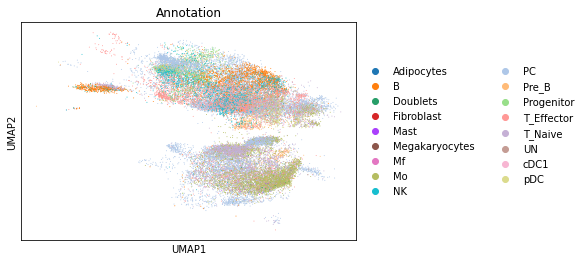

In [21]:
sc.pl.umap(adata_test, wspace=0.5, color=conf.annotation.cell_type_columns)

In [22]:
# evaluation

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_true =  adata_test.obs[conf.annotation.cell_type_columns] == "PC"
y_pred = adata_test.obs["is_pc"]

cm = confusion_matrix(y_true=list(y_true), y_pred=list(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

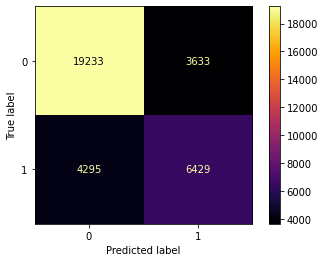

In [24]:
disp.plot(cmap="inferno")
plt.show()

In [47]:
## I will do this in a more orgenized manner later
## scvi representation
import scvi

In [48]:
scvi.data.setup_anndata(adata_train)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 94730 cells, 2908 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [49]:
model = scvi.model.SCVI(adata_train)
model

Make sure the registered X field in anndata contains unnormalized count data.


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [ ]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/84:   0%|          | 0/84 [00:00<?, ?it/s]

The value argument must be within the support of the distribution


Epoch 12/84:  13%|█▎        | 11/84 [23:25<2:40:35, 132.00s/it, loss=460, v_num=1]

In [ ]:
adata_train.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata_train, use_rep="X_scVI", n_neighbors=10)
sc.tl.umap(adata_train, min_dist=0.2)

In [ ]:
adata_train.obs["is_pc"] = adata_train.obs[conf.annotation.cell_type_columns] == "PC"
sc.tl.ingest(adata_test, adata_train, obs='is_pc')
sc.pl.umap(adata_test, wspace=0.5, color=conf.annotation.cell_type_columns)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_true =  adata_test.obs[conf.annotation.cell_type_columns] == "PC"
y_pred = adata_test.obs["is_pc"]

cm = confusion_matrix(y_true=list(y_true), y_pred=list(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

In [ ]:
disp.plot(cmap="inferno")
plt.show()